In [ ]:
from google.colab import files
files.upload()  # Upload file kaggle.json

# Cấu hình API Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Cài đặt thư viện kaggle
!pip install kaggle

# Tải dataset Smart Meters in London và giải nén
!kaggle datasets download jeanmidev/smart-meters-in-london
!unzip -o smart-meters-in-london.zip -d smart_meters

print("\n✅ Hoàn thành Quy trình 1: Tải dữ liệu thành công!")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london
License(s): ODbL-1.0
 97% 1.14G/1.17G [00:05<00:00, 243MB/s]
100% 1.17G/1.17G [00:05<00:00, 241MB/s]
Archive:  smart-meters-in-london.zip
  inflating: smart_meters/acorn_details.csv  
  inflating: smart_meters/daily_dataset.csv  
  inflating: smart_meters/daily_dataset/daily_dataset/block_0.csv  
  inflating: smart_meters/daily_dataset/daily_dataset/block_1.csv  
  inflating: smart_meters/daily_dataset/daily_dataset/block_10.csv  
  inflating: smart_meters/daily_dataset/daily_dataset/block_100.csv  
  inflating: smart_meters/daily_dataset/daily_dataset/block_101.csv  
  inflating: smart_meters/daily_dataset/daily_dataset/block_102.csv  
  inflating: smart_meters/daily_dataset/daily_dataset/block_103.csv  
  inflating: smart_meters/daily_dataset/daily_dataset/block_104.csv  
  inflating: smart_meters/daily_dataset/daily_dataset/block_105.csv  
  inflating: smart_meters/daily_d

In [ ]:
# ===================================================================
# QUY TRÌNH 2: HỢP NHẤT VÀ TIỀN XỬ LÝ DỮ LIỆU (TỪ PROJECT GỐC)
# ===================================================================
import pandas as pd

# 1. Đọc các tệp dữ liệu cần thiết
df_daily = pd.read_csv('smart_meters/daily_dataset.csv')
df_info = pd.read_csv('smart_meters/informations_households.csv')
df_weather = pd.read_csv('smart_meters/weather_hourly_darksky.csv')

# 2. Xử lý dữ liệu thời tiết (từ hàng giờ -> hàng ngày)
df_weather['day'] = pd.to_datetime(df_weather['time']).dt.date
weather_daily = df_weather.groupby('day').agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'windSpeed': 'mean',
    'visibility': 'mean'
}).reset_index()

# 3. Chuyển đổi cột ngày tháng sang định dạng phù hợp để hợp nhất
df_daily['day'] = pd.to_datetime(df_daily['day'])
weather_daily['day'] = pd.to_datetime(weather_daily['day'])

# 4. Hợp nhất dữ liệu tiêu thụ với dữ liệu thời tiết
df_merged = pd.merge(df_daily, weather_daily, on='day', how='left')

# 5. Hợp nhất tiếp với thông tin hộ gia đình
df_full = pd.merge(df_merged, df_info[['LCLid', 'Acorn']], on='LCLid', how='left')

# 6. Xử lý các giá trị thiếu sau khi hợp nhất (dùng ffill)
df_full.sort_values(['LCLid', 'day'], inplace=True)
df_full.ffill(inplace=True)
df_full.bfill(inplace=True)

# 7. Tạo các đặc trưng thời gian
df_full['dayofweek'] = df_full['day'].dt.dayofweek
df_full['month'] = df_full['day'].dt.month
df_full['is_weekend'] = df_full['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

print("\n✅ Hoàn thành Quy trình 2: Dữ liệu đã được hợp nhất và xử lý!")
print(df_full.head())



✅ Hoàn thành Quy trình 2: Dữ liệu đã được hợp nhất và xử lý!
             LCLid        day  energy_median  energy_mean  energy_max  \
2037924  MAC000002 2012-10-12         0.1385     0.154304       0.886   
2037925  MAC000002 2012-10-13         0.1800     0.230979       0.933   
2037926  MAC000002 2012-10-14         0.1580     0.275479       1.085   
2037927  MAC000002 2012-10-15         0.1310     0.213688       1.164   
2037928  MAC000002 2012-10-16         0.1450     0.203521       0.991   

         energy_count  energy_std  energy_sum  energy_min  temperature  \
2037924            46    0.196034       7.098       0.000    11.390000   
2037925            48    0.192329      11.087       0.076     8.591250   
2037926            48    0.274647      13.223       0.070     7.736250   
2037927            48    0.224483      10.257       0.070     9.235833   
2037928            48    0.184115       9.769       0.087    11.607500   

         humidity  windSpeed  visibility    Acorn  day

In [ ]:
# ===================================================================
# QUY TRÌNH 3: XÂY DỰNG HÀM DỰ BÁO (TỪ PROJECT GỐC)
# ===================================================================
!pip install tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# Hàm dự báo cho dữ liệu London (LSTM đa biến)
def run_forecasting_for_household(lcl_id, df_full, epochs=20, time_steps=30, forecast_days=30):
    print(f"\n{'='*50}")
    print(f"🚀 BẮT ĐẦU DỰ BÁO CHO HỘ GIA ĐÌNH LONDON: {lcl_id}")
    print(f"{'='*50}")
    df_house = df_full[df_full['LCLid'] == lcl_id].copy()
    features = ['energy_sum', 'temperature', 'humidity', 'windSpeed', 'dayofweek', 'is_weekend']
    df_features = df_house[features]
    df_features.ffill(inplace=True)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_features)
    def create_multivariate_dataset(data, target_col_index=0, time_steps=30):
        X, y = [], []
        for i in range(len(data) - time_steps):
            X.append(data[i:(i + time_steps), :])
            y.append(data[i + time_steps, target_col_index])
        return np.array(X), np.array(y)
    X, y = create_multivariate_dataset(scaled_data, target_col_index=0, time_steps=time_steps)
    train_size = int(len(X) * 0.9)
    X_train, y_train = X[:train_size], y[:train_size]
    num_features = len(features)
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(time_steps, num_features)),
        LSTM(50), Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    print("\nBắt đầu huấn luyện mô hình LSTM đa biến...")
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0) # verbose=0 để bớt log
    print("Huấn luyện hoàn tất!")
    last_sequence = scaled_data[-time_steps:]
    future_predictions_scaled = []
    current_sequence = last_sequence.reshape(1, time_steps, num_features)
    for _ in range(forecast_days):
        next_pred_scaled = model.predict(current_sequence, verbose=0)[0]
        future_predictions_scaled.append(next_pred_scaled)
        new_row = np.append(next_pred_scaled, current_sequence[0, -1, 1:])
        current_sequence = np.append(current_sequence[:, 1:, :], [[new_row]], axis=1)
    dummy_array = np.zeros((forecast_days, num_features))
    dummy_array[:, 0] = np.array(future_predictions_scaled).flatten()
    future_predictions = scaler.inverse_transform(dummy_array)[:, 0]
    last_date = df_house['day'].max()
    forecast_dates = pd.to_datetime([last_date + pd.DateOffset(days=i) for i in range(1, forecast_days + 1)])
    plt.figure(figsize=(15, 6))
    plt.plot(df_house['day'][-100:], df_house['energy_sum'][-100:], label='Lịch sử tiêu thụ (100 ngày gần nhất)')
    plt.plot(forecast_dates, future_predictions, label=f'Dự báo {forecast_days} ngày tới', color='red', linestyle='--')
    plt.title(f'Dự báo Tiêu thụ Điện cho Hộ gia đình {lcl_id} (London)')
    plt.xlabel('Ngày'); plt.ylabel('Tiêu thụ điện (kWh)'); plt.legend(); plt.grid(True); plt.show()

print("\n✅ Hoàn thành Quy trình 3: Hàm dự báo cho dữ liệu London đã sẵn sàng!")


✅ Hoàn thành Quy trình 3: Hàm dự báo cho dữ liệu London đã sẵn sàng!



🚀 BẮT ĐẦU DỰ BÁO CHO HỘ GIA ĐÌNH LONDON: MAC000150


/tmp/ipython-input-315781420.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.ffill(inplace=True)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Bắt đầu huấn luyện mô hình LSTM đa biến...
Huấn luyện hoàn tất!


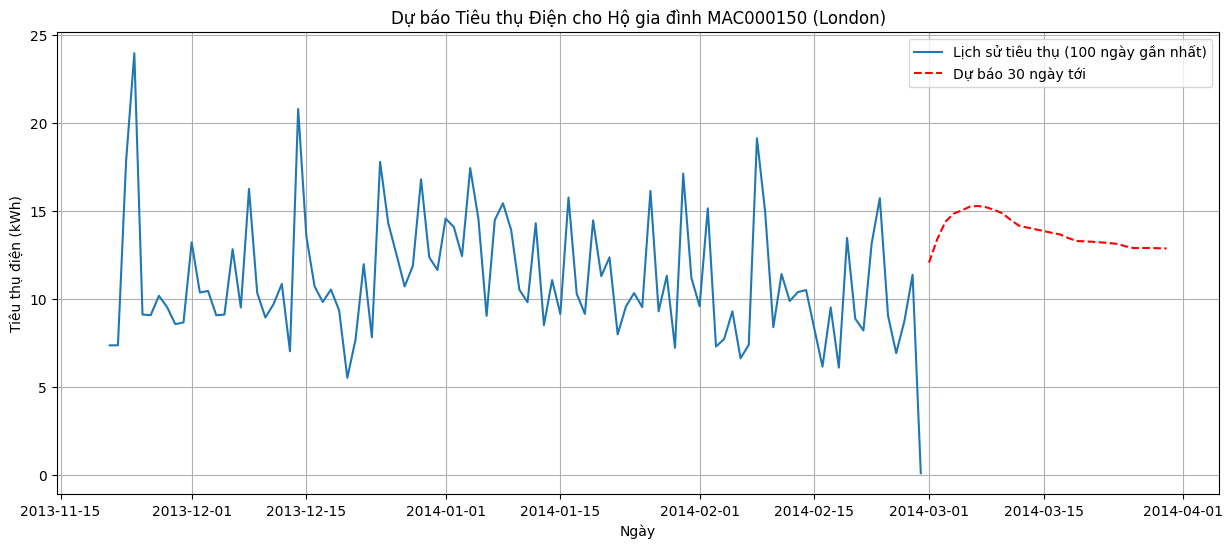


🎉 Hoàn thành Quy trình 4: Phân tích trên dữ liệu London.


In [ ]:
# ===================================================================
# QUY TRÌNH 4: THỰC THI VÀ PHÂN TÍCH (VỚI DỮ LIỆU LONDON)
# ===================================================================

# Chạy hàm dự báo cho một hộ gia đình cụ thể trong bộ dữ liệu London
run_forecasting_for_household(lcl_id='MAC000150', df_full=df_full, epochs=10) # Giảm epochs để chạy nhanh hơn

print("\n🎉 Hoàn thành Quy trình 4: Phân tích trên dữ liệu London.")


🇻🇳 BẮT ĐẦU QUY TRÌNH 5: DỰ BÁO DỮ LIỆU THỰC TẾ TẠI VIỆT NAM

--- Dữ liệu tiêu thụ điện hàng ngày thực tế (Tháng 08/2025) ---
            san_luong
ngay                 
2025-08-01       7.00
2025-08-02       8.19
2025-08-03       7.89
2025-08-04       8.25
2025-08-05       7.82
-------------------------------------------------------

=> DỰ ĐOÁN TỔNG SẢN LƯỢNG TIÊU THỤ THÁNG 09/2025: 188.76 KWH
-------------------------------------------------------


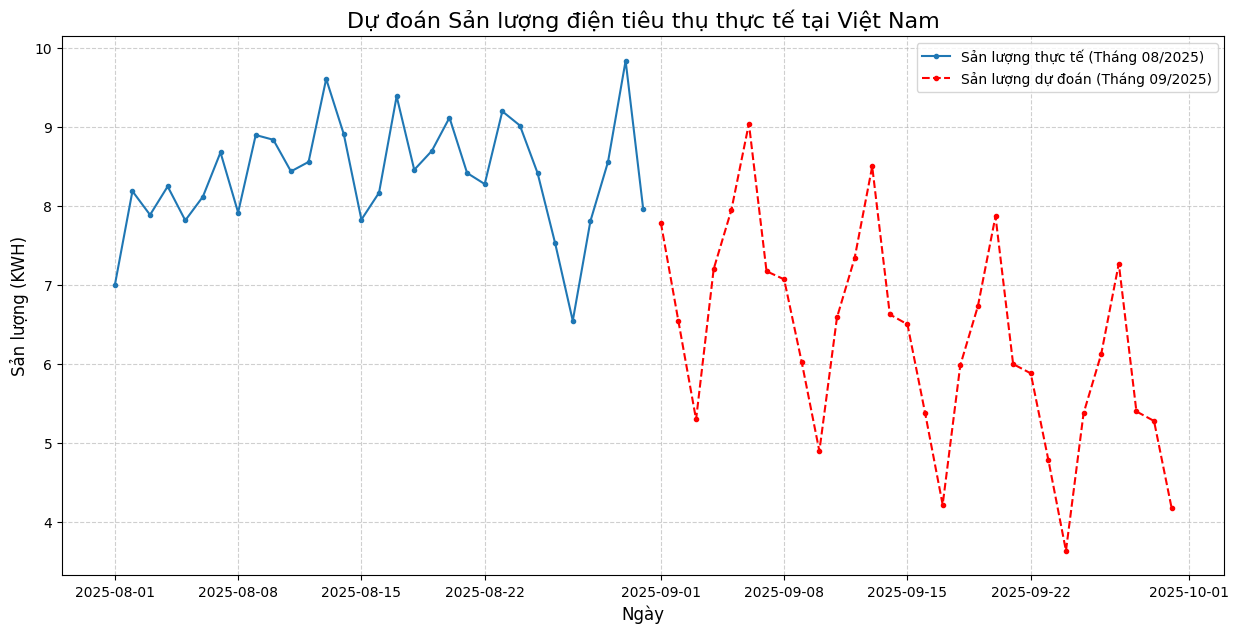


🎉 Hoàn thành Quy trình 5: Đã tích hợp và dự đoán trên dữ liệu thực tế.


In [ ]:
# ===================================================================
# QUY TRÌNH 5: XỬ LÝ VÀ DỰ BÁO DỮ LIỆU THỰC TẾ (VIỆT NAM) - MỚI
# ===================================================================
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")

print(f"\n{'='*60}")
print("🇻🇳 BẮT ĐẦU QUY TRÌNH 5: DỰ BÁO DỮ LIỆU THỰC TẾ TẠI VIỆT NAM")
print(f"{'='*60}")

# 1. Nhập dữ liệu thực tế từ tháng 08/2025
data_thuc_te = {
    '2025-08-01': 7.0, '2025-08-02': 8.19, '2025-08-03': 7.89, '2025-08-04': 8.25,
    '2025-08-05': 7.82, '2025-08-06': 8.12, '2025-08-07': 8.68, '2025-08-08': 7.92,
    '2025-08-09': 8.9, '2025-08-10': 8.84, '2025-08-11': 8.44, '2025-08-12': 8.56,
    '2025-08-13': 9.61, '2025-08-14': 8.91, '2025-08-15': 7.83, '2025-08-16': 8.17,
    '2025-08-17': 9.39, '2025-08-18': 8.46, '2025-08-19': 8.7, '2025-08-20': 9.12,
    '2025-08-21': 8.42, '2025-08-22': 8.28, '2025-08-23': 9.2, '2025-08-24': 9.02,
    '2025-08-25': 8.42, '2025-08-26': 7.53, '2025-08-27': 6.55, '2025-08-28': 7.81,
    '2025-08-29': 8.56, '2025-08-30': 9.84, '2025-08-31': 7.96
}

# Tạo DataFrame
df_vn = pd.DataFrame(list(data_thuc_te.items()), columns=['ngay', 'san_luong'])
df_vn['ngay'] = pd.to_datetime(df_vn['ngay'])
df_vn.set_index('ngay', inplace=True)

print("\n--- Dữ liệu tiêu thụ điện hàng ngày thực tế (Tháng 08/2025) ---")
print(df_vn.head())
print("-" * 55)

# 2. Xây dựng và huấn luyện mô hình SARIMA
# SARIMA là một mô hình thống kê mạnh cho chuỗi thời gian, phù hợp khi không có nhiều đặc trưng phụ.
# (p,d,q): Tham số cho phần không theo mùa. (1,1,1) là một lựa chọn phổ biến.
# (P,D,Q,m): Tham số cho phần theo mùa. m=7 vì dữ liệu có tính chu kỳ theo tuần.
model_sarima = SARIMAX(df_vn['san_luong'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 7))

model_fit_sarima = model_sarima.fit(disp=False)

# 3. Dự đoán cho 30 ngày tiếp theo (Tháng 09/2025)
forecast_steps = 30
forecast = model_fit_sarima.forecast(steps=forecast_steps)
tong_du_doan = forecast.sum()

print(f"\n=> DỰ ĐOÁN TỔNG SẢN LƯỢNG TIÊU THỤ THÁNG 09/2025: {tong_du_doan:.2f} KWH")
print("-" * 55)

# 4. Trực quan hóa kết quả
forecast_dates = pd.date_range(start=df_vn.index.max() + pd.Timedelta(days=1), periods=forecast_steps)

plt.figure(figsize=(15, 7))
plt.plot(df_vn.index, df_vn['san_luong'], marker='.', linestyle='-', label='Sản lượng thực tế (Tháng 08/2025)')
plt.plot(forecast_dates, forecast, marker='.', linestyle='--', color='red', label='Sản lượng dự đoán (Tháng 09/2025)')
plt.title('Dự đoán Sản lượng điện tiêu thụ thực tế tại Việt Nam', fontsize=16)
plt.ylabel('Sản lượng (KWH)', fontsize=12)
plt.xlabel('Ngày', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n🎉 Hoàn thành Quy trình 5: Đã tích hợp và dự đoán trên dữ liệu thực tế.")